# Imports

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Global Vars.

In [27]:
results = {}

RANDOM_FOREST = 'Random Forest'
LOGISTIC_REGRESSION = 'Logistic Regression'
XGBOOST = 'XGBoost'

# Helpers

In [28]:
def lorenz_curve(array):
    array = np.sort(array)
    cumulative_values = np.cumsum(array)
    cumulative_values = np.insert(cumulative_values, 0, 0)
    cumulative_values = cumulative_values / cumulative_values[-1]
    gini = 1 - 2 * np.trapezoid(cumulative_values, dx=1/len(array))
    return cumulative_values, gini


def entropy(array):
    _, counts = np.unique(array, return_counts=True)
    probabilities = counts / len(array)
    return -np.sum(probabilities * np.log2(probabilities))


# Reading data from CSV

In [29]:
data = pd.read_csv('ufo-sightings.csv', sep=',', index_col=0)
data = data.dropna()
data = data.drop_duplicates()

# Displaying data

In [30]:
display(data)

,Date_time,date_documented,Year,Month,Hour,Season,Country_Code,Country,Region,Locale,latitude,longitude,UFO_shape,length_of_encounter_seconds,Encounter_Duration,Description
0,1949-10-10 20:30:00,4/27/2004,1949,10,20,Autumn,USA,United States,Texas,San Marcos,29.883056,-97.941111,Cylinder,2700.0,45 minutes,This event took place in early fall around 194...
1,1949-10-10 21:00:00,12/16/2005,1949,10,21,Autumn,USA,United States,Texas,Bexar County,29.384210,-98.581082,Light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...
2,1955-10-10 17:00:00,1/21/2008,1955,10,17,Autumn,GBR,United Kingdom,England,Chester,53.200000,-2.916667,Circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...
3,1956-10-10 21:00:00,1/17/2004,1956,10,21,Autumn,USA,United States,Texas,Edna,28.978333,-96.645833,Circle,20.0,1/2 hour,My older brother and twin sister were leaving ...
4,1960-10-10 20:00:00,1/22/2004,1960,10,20,Autumn,USA,United States,Hawaii,Kaneohe,21.418056,-157.803611,Light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80323,2013-09-09 21:15:00,9/30/2013,2013,9,21,Autumn,USA,United States,Tennessee,Nashville,36.165833,-86.784444,Light,600.0,10 minutes,Round from the distance/slowly changing colors...
80324,2013-09-09 22:00:00,9/30/2013,2013,9,22,Autumn,USA,United States,Idaho,Boise,43.613611,-116.202500,Circle,1200.0,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...
80325,2013-09-09 22:00:00,9/30/2013,2013,9,22,Autumn,USA,United States,California,Napa Abajo,38.297222,-122.284444,Other,1200.0,hour,Napa UFO&#44
80326,2013-09-09 22:20:00,9/30/2013,2013,9,22,Autumn,USA,United States,Virginia,Vienna,38.901111,-77.265556,Circle,5.0,5 seconds,Saw a five gold lit cicular craft moving fastl...


# Describe database

In [31]:
data.describe()

,Year,Month,Hour,latitude,longitude,length_of_encounter_seconds
count,77668.000000,77668.000000,77668.000000,77668.000000,77668.000000,7.766800e+04
mean,2003.972176,6.853608,15.554166,38.208221,-87.605826,8.055533e+03
std,10.405113,3.226473,7.731410,10.084687,37.680699,5.994055e+05
min,1910.000000,1.000000,0.000000,-46.413187,-176.658056,1.000000e-03
25%,2001.000000,4.000000,10.000000,34.147569,-112.073333,3.000000e+01
50%,2007.000000,7.000000,19.000000,39.399835,-87.924167,1.800000e+02
75%,2011.000000,9.000000,21.000000,42.732500,-78.886944,6.000000e+02
max,2014.000000,12.000000,23.000000,72.700000,178.441900,9.783600e+07


# Histogram

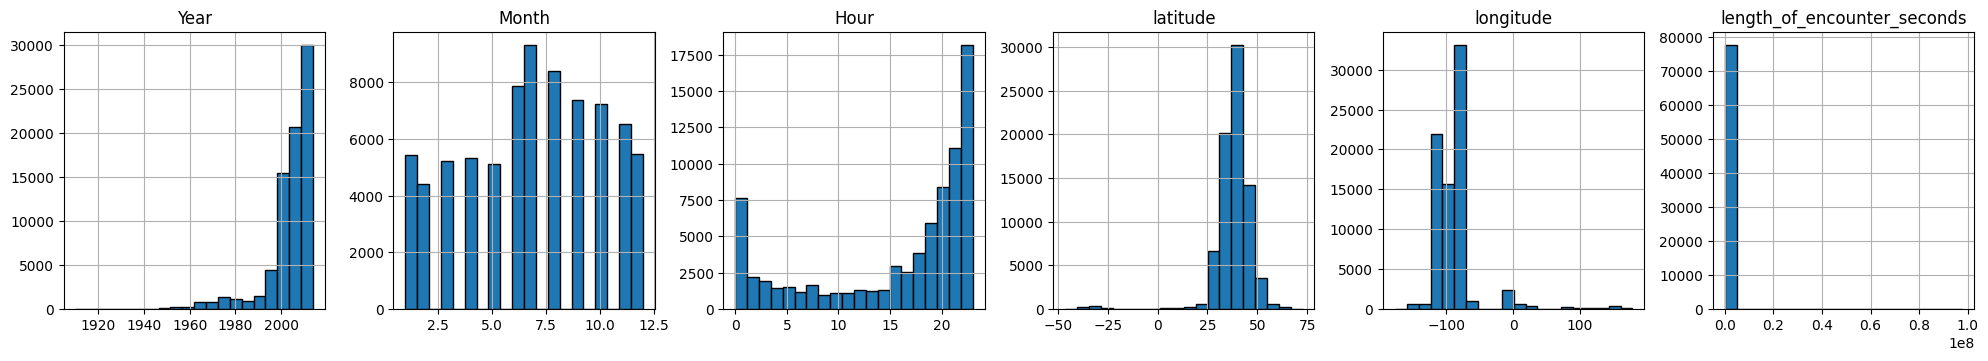

In [32]:
data.hist(figsize=(20, 20), bins=20, layout=(6, 6), edgecolor='black')
plt.tight_layout()
plt.show()

# Gini index

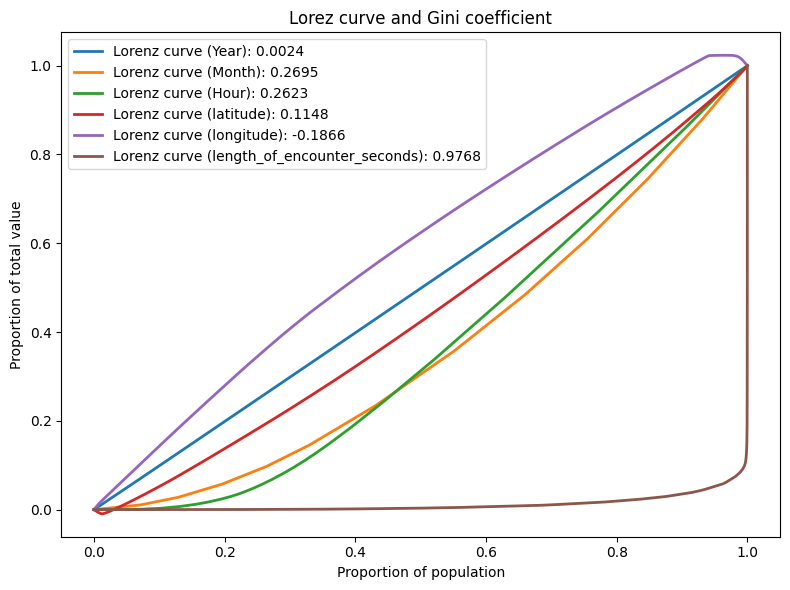

In [33]:
numeric_cols = data.select_dtypes(include=[np.number])

gini_values = {}

for col in numeric_cols.columns:
    values = numeric_cols[col].dropna().values
    cumulative_values, gini = lorenz_curve(values)
    gini_values[col] = (cumulative_values, gini)

plt.figure(figsize=(8, 6))

for col, (cumulative_values, gini) in gini_values.items():
    x_values = np.linspace(0, 1, len(cumulative_values))
    plt.plot(x_values, cumulative_values, label=f'Lorenz curve ({col}): {gini:.4f}', linewidth=2)

plt.title('Lorez curve and Gini coefficient')
plt.xlabel('Proportion of population')
plt.ylabel('Proportion of total value')
plt.legend()
plt.tight_layout()
plt.show()


# Information Quantity

Entropy for Year: 4.6990
Entropy for Month: 3.5482
Entropy for Hour: 4.0509
Entropy for latitude: 12.5916
Entropy for longitude: 12.6680
Entropy for length_of_encounter_seconds: 4.9214


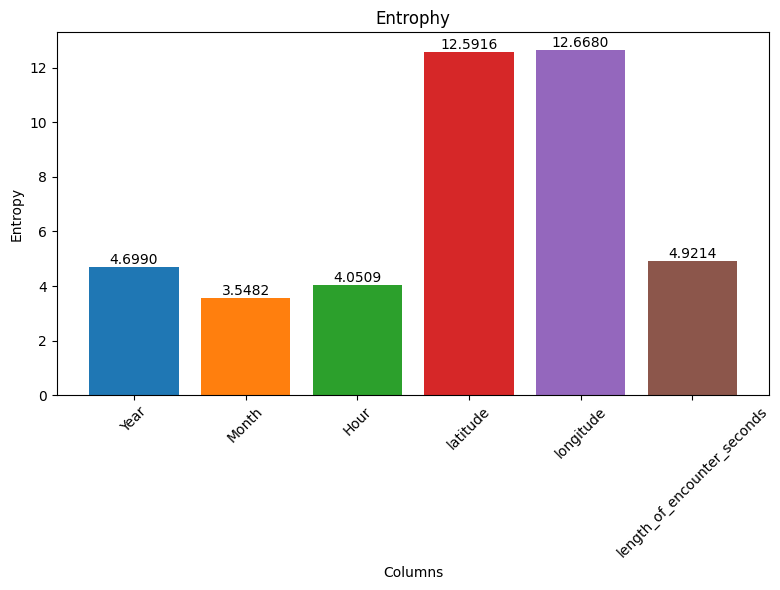

In [34]:
entropy_values = {}
for col in numeric_cols.columns:
    values = numeric_cols[col].dropna().values
    ent = entropy(values)
    entropy_values[col] = ent

plt.figure(figsize=(8, 6))
for col, ent in entropy_values.items():
    plt.bar(col, ent)
    plt.text(col, ent, f'{ent:.4f}', ha='center', va='bottom')
    print(f'Entropy for {col}: {ent:.4f}')

plt.title('Entrophy')
plt.xlabel('Columns')
plt.ylabel('Entropy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation

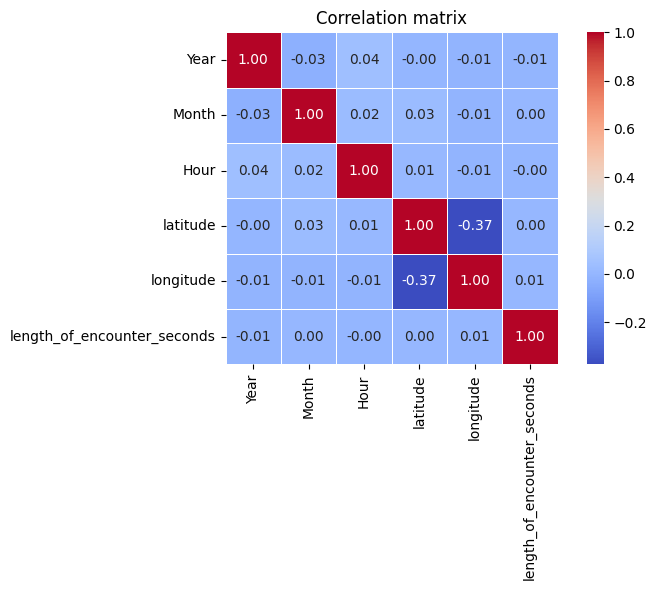

In [35]:
correlation_matrix = numeric_cols.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)

ax = plt.gca()

plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

# Prepare UFO shapes

In [36]:
min_class_count = 10
shape_counts = data['UFO_shape'].value_counts()
rare_shapes = shape_counts[shape_counts < min_class_count].index
data['UFO_shape'] = data['UFO_shape'].replace(rare_shapes, 'Other_Rare')

# Define X and y

In [37]:
y = data['UFO_shape']
X = data.drop(columns=['UFO_shape'])
X = X.select_dtypes(include=[np.number])

# Train/Test Split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Random Forest

In [39]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

y_pred_rf = grid_rf.best_estimator_.predict(X_test)
results[RANDOM_FOREST] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'classification_report': classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0),
    'best_params': grid_rf.best_params_
}

# Logistic Regression (Pipeline)

In [40]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
], memory=None)

param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear', 'lbfgs']
}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train)

y_pred_lr = grid_lr.best_estimator_.predict(X_test)
results[LOGISTIC_REGRESSION] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'classification_report': classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0),
    'best_params': grid_lr.best_params_
}

# XGBoost

In [41]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(objective='multi:softprob',
                                 eval_metric='mlogloss',
                                 random_state=42))
], memory=None)

param_grid_xgb = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.1, 0.3],
    'classifier__subsample': [0.8, 1],
    'classifier__colsample_bytree': [0.8, 1]
}

grid_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train_encoded)

y_pred_encoded = grid_xgb.best_estimator_.predict(X_test)
y_pred_xgb = le.inverse_transform(y_pred_encoded)

results[XGBOOST] = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'classification_report': classification_report(y_test, y_pred_xgb, output_dict=True, zero_division=0),
    'best_params': grid_xgb.best_params_
}

# Results

In [42]:
print("=== Model Comparison ===\n")
for model, res in results.items():
    print(f"{model}:")
    print(f"  Accuracy: {res['accuracy']:.4f}")
    print(f"  Best Params: {res['best_params']}")
    print()


best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"Best model based on accuracy: {best_model_name}")

=== Model Comparison ===

Random Forest:
  Accuracy: 0.1983
  Best Params: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}

Logistic Regression:
  Accuracy: 0.2187
  Best Params: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}

XGBoost:
  Accuracy: 0.2271
  Best Params: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 1}

Best model based on accuracy: XGBoost


# Analysis for instances


Explicare pentru Instanța 0:
Valori caracteristici:
Year                           2004.000000
Month                             7.000000
Hour                             23.000000
latitude                         33.894339
longitude                       -78.426672
length_of_encounter_seconds     600.000000
Name: 60573, dtype: float64
Clasa reală: Fireball
Clasa prezisă: Light

Importanța caracteristicilor (feature importance):
Hour                           0.195905
Year                           0.182700
length_of_encounter_seconds    0.170649
Month                          0.150946
longitude                      0.150577
latitude                       0.149222
dtype: float32


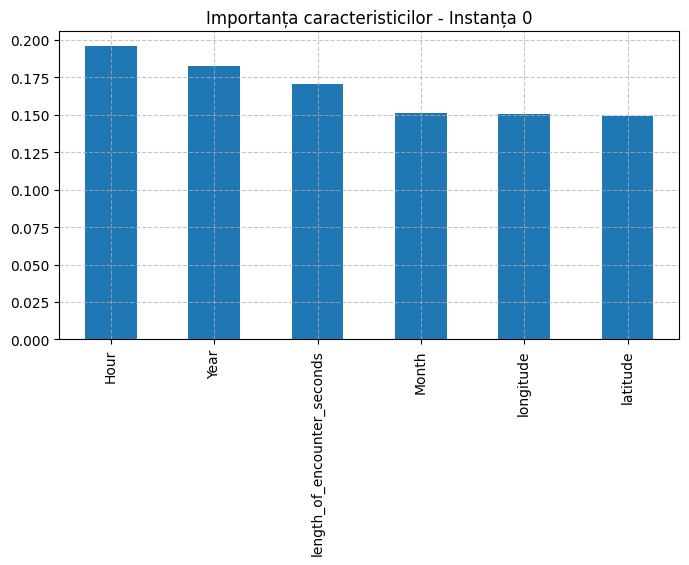


Explicare pentru Instanța 1:
Valori caracteristici:
Year                           1966.000000
Month                             6.000000
Hour                              0.000000
latitude                         14.058324
longitude                       108.277199
length_of_encounter_seconds     480.000000
Name: 52677, dtype: float64
Clasa reală: Circle
Clasa prezisă: Light

Importanța caracteristicilor (feature importance):
Hour                           0.195905
Year                           0.182700
length_of_encounter_seconds    0.170649
Month                          0.150946
longitude                      0.150577
latitude                       0.149222
dtype: float32


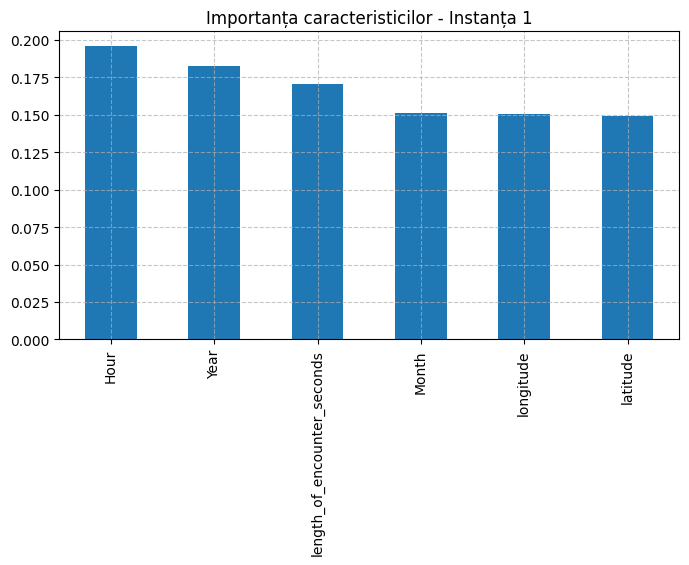


Explicare pentru Instanța 2:
Valori caracteristici:
Year                           1999.000000
Month                            11.000000
Hour                             17.000000
latitude                         53.007732
longitude                        -1.433412
length_of_encounter_seconds     600.000000
Name: 13948, dtype: float64
Clasa reală: Unknown
Clasa prezisă: Triangle

Importanța caracteristicilor (feature importance):
Hour                           0.195905
Year                           0.182700
length_of_encounter_seconds    0.170649
Month                          0.150946
longitude                      0.150577
latitude                       0.149222
dtype: float32


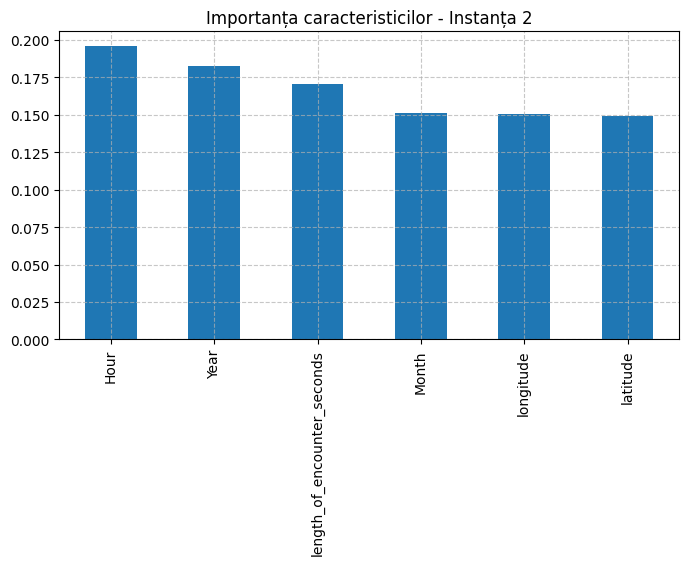


Explicare pentru Instanța 3:
Valori caracteristici:
Year                           2012.000000
Month                             9.000000
Hour                              0.000000
latitude                         47.979167
longitude                      -122.200833
length_of_encounter_seconds      10.000000
Name: 73999, dtype: float64
Clasa reală: Triangle
Clasa prezisă: Light

Importanța caracteristicilor (feature importance):
Hour                           0.195905
Year                           0.182700
length_of_encounter_seconds    0.170649
Month                          0.150946
longitude                      0.150577
latitude                       0.149222
dtype: float32


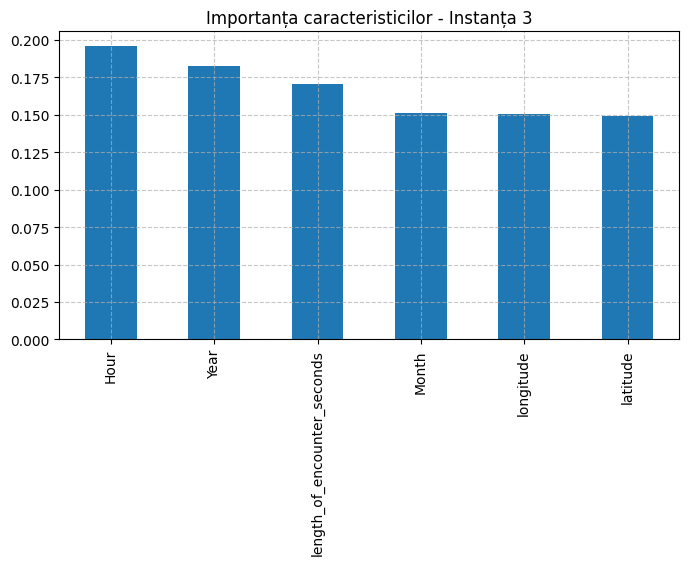


Explicare pentru Instanța 4:
Valori caracteristici:
Year                           1974.000000
Month                             4.000000
Hour                             23.000000
latitude                         33.520556
longitude                       -86.802500
length_of_encounter_seconds     180.000000
Name: 38257, dtype: float64
Clasa reală: Disk
Clasa prezisă: Disk

Importanța caracteristicilor (feature importance):
Hour                           0.195905
Year                           0.182700
length_of_encounter_seconds    0.170649
Month                          0.150946
longitude                      0.150577
latitude                       0.149222
dtype: float32


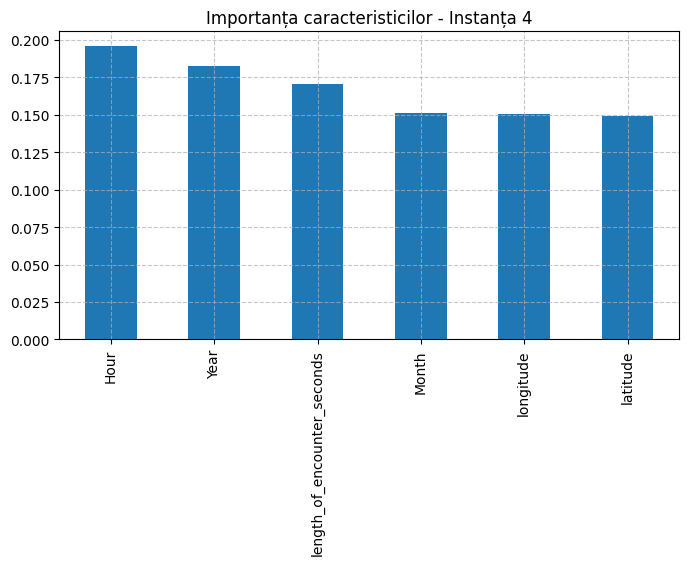

In [43]:
xgb_model = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, le.fit_transform(y_train))

y_pred_raw = xgb_model.predict(X_test)
y_pred_xgb_nb = le.inverse_transform(y_pred_raw)
y_proba_xgb = xgb_model.predict_proba(X_test)

instances = [0, 1, 2, 3, 4]
for idx in instances:
    print(f"\nExplicare pentru Instanța {idx}:")
    print("Valori caracteristici:")
    print(X_test.iloc[idx])
    print(f"Clasa reală: {y_test.iloc[idx]}")
    print(f"Clasa prezisă: {y_pred_xgb_nb[idx]}")
    print("\nImportanța caracteristicilor (feature importance):")
    
    feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
    sorted_importances = feature_importances.sort_values(ascending=False)
    print(sorted_importances.head(10))
    
    plt.figure(figsize=(8, 4))
    sorted_importances.head(10).plot(kind='bar')
    plt.title(f'Importanța caracteristicilor - Instanța {idx}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Interpretarea rezultatelor pentru primele 5 instante din set:
- Instanta 0: Modelul a prezis Light in loc de Fireball, principala cauza fiind ora tarzie (23) si cu o durata mare (10 minute), modelul s-a bazat prea mult pe ora tarzie cel mai probabil si in mod normal a spus ca noaptea cel mai des se pot vedea lumini 
- Instanta 1: Modelul a prezis Light in loc de Circle, principala cauza fiind ca in instanta 0, fiind de asemenea o ora tarzie (0) si cu o durata medie (8 minutes), modelul avand lacune despre zona (Vietnam) s-a dus dupa prima varianta care era de asteptat (Light)
- Instanta 2: Modelul a prezis Triangle in loc de Unknown, principala cauza fiind faptul ca in Marea Britanie la o ora tarzie (17) mai ales intr-o luna ca Noiembrie unde ziua este mai scurta decat noaptea si o durata mare (10 minute), modelul crede ca forma era clara fiind cerul inchis si favorizeaza o forma regulata, pe cand adevarul este ca forma nici macar nu a fost categorizata, ea fiind Unknown (stea stralucitoare).
- Instanta 3: Modelul a prezis Light in loc de Triangle, principala cauza fiind durata extrem de scurta (10 secunde) la o ora tarzie (0), modelul a asociat cu clasa Light
- Instanta 4: Modelul a prezis clasa corecta (Disk), durata medie (3 minute) si ora tarzie (23), impreuna cu locatia (Statele Unite ale Americii), par sa fie folosite eficient de model si sa asocieze cu forma de disc, posibil sa fie si de la frecventa de date asemanatoare.

# Concluzii generale:
- Modelul favorizeaza clasa Light in conditii de noapte si durate scurte sau medii
- Caracteristicile Hour si length_of_encounter_seconds sunt factorii principali in preziceri
- Anumite confuzii vin din cauza lacunelor (lipsa de detalii concise) sau din amestecarea exagerata a cazurilor de noapte

# Rezultate si explicatii:
- Hour (ora observatiei) este caracteristica care influenteaza cel mai mult in luarea deciziilor. Observatiile realizate la ore inaintate au fost frecvent asociate cu forma Light, ceea ce este normal deoarece fenomenele luminoase sunt mult mai usor de vazut si raportat noaptea. Aceasta concluzie este sustinuta si de literatura de specialitate unde se specifica faptul ca majoritatea rapoartelor apar in lipsa luminii naturale.
- Year (anul observatiei) este o caracteristica cu o importanta in calitatea informatiilor, cu cat mergem mai adanc in baza de date, informatiile par mai calitative si sustin o probabilitate crescuta pentru forme clare.
- Length_of_encounter_seconds (Durata intalnirii) este o caracteristica importanta in predictii. Evenimentele cu o durata medie spre lunga (cel putin 5 minute) au fost frecvent asociate cu forme solide precum Fireball, Triangle sau Disk si evenimentele cu o durata scurta (sub 30 de secunde) sunt frecvent asociate cu clasa Light. Logica din spatele acestor concluzii este valida deoarece cu cat evenimentul este mai lung, perceptiile fugitive devin viziuni concrete. 
- Coordonate georgrafice (latitudine si longitudine) sunt un factor indirect important, avand in vedere faptul ca observatiile din Statele Unite ale Americii au o acuratete crescuta din cauza densitatii rapoartelor, iar locatiile din Asia, Africa au o acuratete scazuta.
- Month (luna observatiei) contribuie la acuratetea rapoartelor si nu putem sa ignoram aceasta caracteristica deoarece in lunile de vara de exemplu cerul este mai senin in cea mai mare parte a zilei si oamenii petrec mai mult timp afara ceea ce induce la o densitate mai mare a rapoartelor dar si o precizie mai crescuta a informatiilor

# Interpretare generala si coerenta cu literatura fenomenului OZN
Modelul, in ciuda faptului ca este limitat la numarul de caracteristici cu caracter numeric, a invatat cateva tipare valide si concrete cu ce se cunoaste in studiile despre OZN-uri:
- Light este forma dominanta noaptea, la durate scurte dar nu sunt asa de precise
- Disk si Triangle sunt formele dominante la evenimentele cu o durata medie spre lunga, locatii des intalnite si observatii recente
- Unknown apare mai des in evenimentele cu caracteristici rare (locatii cu putine aparitii, durate scurte spre medii si perioade vechi)

# Concluzii:
- Modelul este limitat in zonele slab prezente in rapoarte si forme cu aparitii rare (ceea ce este normal)
- Necesita imbunatatiri prin adaugarea unor caracteristici noi (de exemplu, am putea adauga gradul intalnirii care reprezinta distanta dintre OZN si privitor sau numarul martorilor la eveniment)
- Caracteristicile temporale (ora, anul, luna) au impact semnificativ asupra clasificarii
- Un model mai complex ar trebui sa ia in considerare si descrierea evenimentului
- Formele luminoase sunt cele mai frecvent raportate in conditii de vizibilitate redusa, confirmand ipoteza ca lumina este mai usor de perceput in intuneric